In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import logging
logging.basicConfig(level="WARN")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


import timeseries_utils as ts
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10, 5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
data = pd.read_csv('uber-raw-data-janjune-15.csv',usecols=['Pickup_date'])

Let's convert Pickup_date to a datetime object, set it as index and aggregate by hour buckets.

In [9]:
data['Pickup_date'] = pd.to_datetime(data['Pickup_date']).dt.floor('H')
data.set_index('Pickup_date', drop=True, inplace=True)

In [62]:
df = pd.DataFrame(data.groupby('Pickup_date').size(),columns=['total_pickups'])

In [63]:
df.head()

,total_pickups
Pickup_date,
2015-01-01 00:00:00,6465
2015-01-01 01:00:00,6001
2015-01-01 02:00:00,7171
2015-01-01 03:00:00,5874
2015-01-01 04:00:00,3529


Let's reindex the dataframe to have a uniformly sampled dataset

In [64]:
idx = pd.date_range(start=df.index.values[0],end=df.index.values[-1],freq='H')

In [65]:
df = df.reindex(index=idx)

For simplicity, since there are only 10 missing values, we'll use pandas bfill method

In [66]:
df[df['total_pickups'].isnull()]

,total_pickups
2015-01-26 23:00:00,NaN
2015-01-27 00:00:00,NaN
2015-01-27 01:00:00,NaN
2015-01-27 02:00:00,NaN
2015-01-27 03:00:00,NaN
2015-01-27 04:00:00,NaN
2015-01-27 05:00:00,NaN
2015-01-27 06:00:00,NaN
2015-01-27 07:00:00,NaN
2015-03-08 02:00:00,NaN


In [67]:
df.fillna(method='bfill', inplace=True)

Before we begin with the analysis, it's always a good idea to visualize the data and get some summary statistics

Total uber rides: total_pickups    14275210.0
dtype: float64
Hourly pickups summary

       total_pickups
count    4344.000000
mean     3286.190147
std      1820.438156
min       159.000000
25%      1879.000000
50%      3178.500000
75%      4475.500000
max     10647.000000


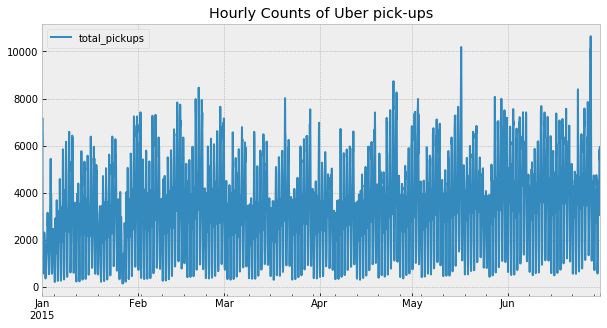

In [68]:
print(f"Total uber rides: {df.sum()}")
print("Hourly pickups summary\n")
print(df.describe())
df.plot(kind='line',title="Hourly Counts of Uber pick-ups")

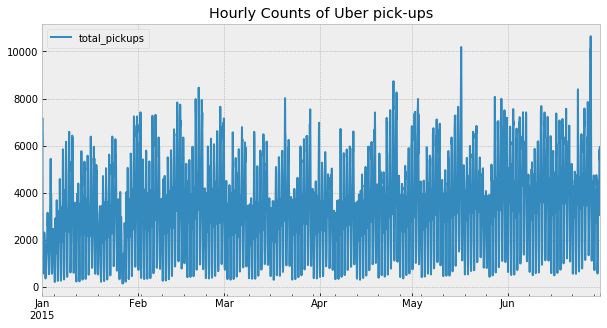

In [69]:
ax = df.plot(kind='line',title="Hourly Counts of Uber pick-ups");
fig = ax.get_figure()
fig.savefig('Hourly_counts.png');

As one would expect, the data is periodic. The max number of hourly pick-ups ~10500 and the min is about 160, while we have a total of over 14 million pick-ups!
Given this behavior, it difficult to pick-out any trends or outliers. To get a better sense of the distribution, let's plot a histogram and a boxplot

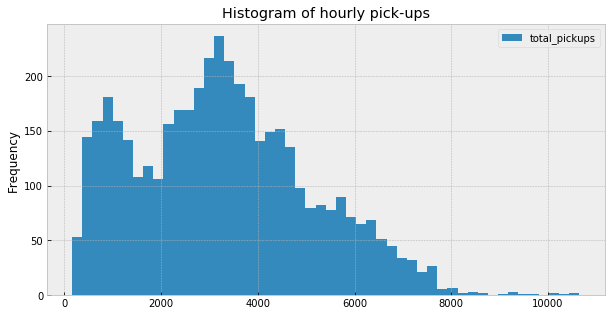

In [70]:
df.plot.hist(bins=50, title="Histogram of hourly pick-ups")

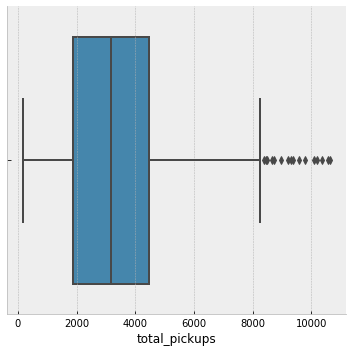

In [71]:
sns.catplot(x='total_pickups',kind='box',data=df)

As one may expect, the data is not normal and it is highly skewed. In the sections below, we'll examine a few standard techniques for standardizing data as well as for event detection

# Data Preprocessing and Analysis
We'll discuss 4 main areas of time series analyis:

1. Standardizing
2. Time series decomposition - additive and multiplicative decomposition
3. Detecting Seasonality - Discrete Fourier Transform
4. Trend removal - rolling mean/median

At the end, all the above methods will be combined to implement a simple event detection algorithm

# Standardize

It is generally good practice and useful to rescale the data in such a way to have zero-mean and unit variance, i.e. in units of z-scores. This is easily accomplished by subtracting the mean and dividing by the standard deviance. Pandas makes this a breeze.

In [25]:
def normalize(df):
    """
    Rescales dataframe in z-score units
    """
    return (df-df.mean())/df.std()

In [26]:
df = normalize(df)

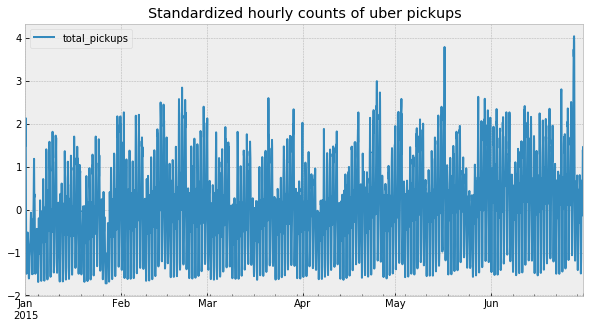

In [27]:
df.plot(kind='line',title='Standardized hourly counts of uber pickups')

Aside from the obvious periodicity, we can also discern a subtle upward trend.

# Time series Decomposition

A common way to analyze time series is to make an assumption about the underlying process. For instance, in ordinary least squares, one assumes the dependent variable depends linearly on the independent variable plus some noise:

\begin{equation}
y_{i} = \sum_{ij}x_{ij}\beta_{j} + \varepsilon_{i}
\end{equation}

Time series decomposition is a procedure that aims to separate a time series into its constituents. The original time series is normally decomposed into three parts: trend, seasonality, and noise. Furthermore, the more common ways to decompose the time series are respectively additive and multiplicative:

\begin{eqnarray}
    y_t &=& S_t + T_t + \varepsilon_t \\
    y_t &=& S_t\times T_t\times\varepsilon_t
\end{eqnarray}

For the remaining of this analysis, we'll assume that the time series can be additively decomposed.

# Detecting Seasonality

The first step to decompose our time series is the detection and removal of the underlying seasonality, i.e. periodicity. By looking at counts vs. time plot, we can get an idea of what this periocity should be. However, we will make this more formal by calculating it via the discrete Fourier transform.

Let's plot the hourly counts for the first 100 hours.

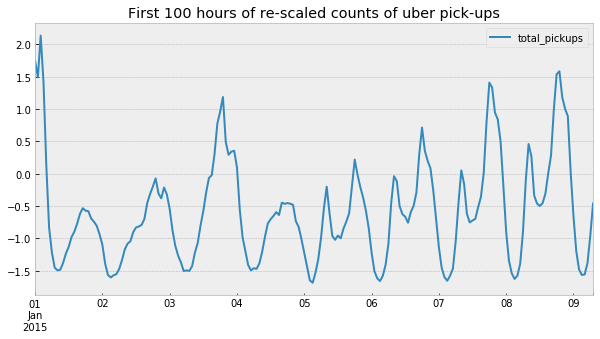

In [28]:
df.iloc[:200].plot(kind='line',title='First 100 hours of re-scaled counts of uber pick-ups')

It looks like the period is about one day. Let's confirm this is consistent throughout the data.

The Fourier transform is defined as:
\begin{equation}
d(\omega_{j}) = \frac{1}{\sqrt{N}}\sum_{t=1}^{N}x_{t}e^{-2i\pi\omega_{j}t},
\end{equation}

for $j\in \mathbb{Z}$, where $\omega_{j} = j/N$ are called the fundamental frequencies. We can now calculate the distribution of power into frequency components of the signal. In other words, we shall compute the spectral density, since we only have a finite sample of the signal, this is usually referred to as *periodogram*, defined as:

\begin{equation}
I(\omega_{j}) = \left|d\left(\omega_{j}\right)\right|^{2}.
\end{equation}

In [29]:
d = np.fft.rfft(df['total_pickups'],norm='ortho')

In [30]:
p = np.abs(d)**2

In [31]:
f = np.fft.rfftfreq(len(df))

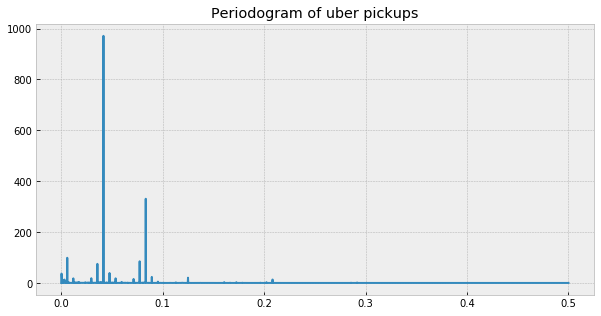

In [32]:
plt.plot(f,p)
plt.title("Periodogram of uber pickups")

We can now find the seasonality period by finding where peaks in the plot above happen.

In [33]:
s = f[np.argmax(p)]

In [34]:
t = 1/s
print("Length of seasonality %.2f hours" % t)

Length of seasonality 24.00 hours


As expected the data displays a seasonal pattern of approximately 24 hours.

# Detecting Trend

One of the most common methods to detect and remove the trend component of a time series is the moving average of a fixed size window. This can be viewed as a one-dimensional convolution operator with a kernel of length $m$, with $m$ being the size of the window. The moving average will effectively smooth out our signal. It's generally important to use a window size equal to the seasonality component.

Let's take a look at our signal with a window of size 24.

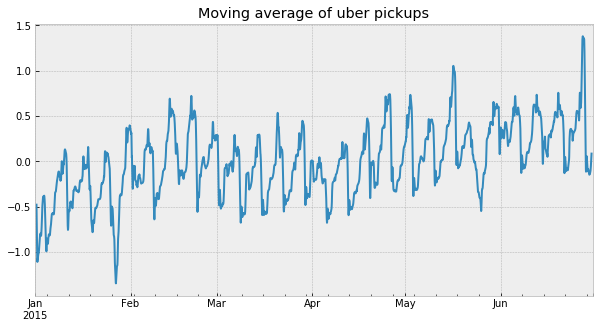

In [35]:
df['total_pickups'].rolling(24,center=True).mean().plot(kind='line',title='Moving average of uber pickups')

# Combine transformations

We can now combine the methods described above and use them to detect anomalies. I wrote a couple of utility functions that can be used for trend and seasonality extraction that can be found here.

In [37]:
seasonal = ts.get_seasonality(df['total_pickups'],24)
seasonal.index = idx

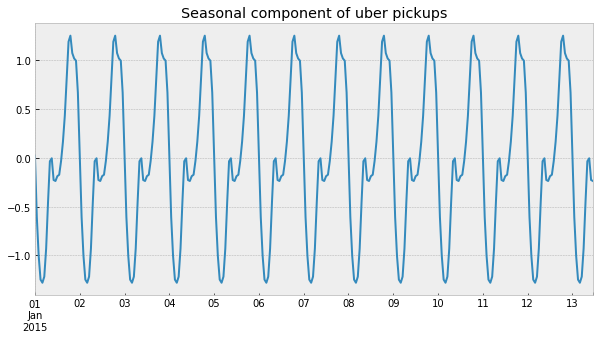

In [38]:
seasonal[:300].plot(kind='line',title='Seasonal component of uber pickups')

In [39]:
trend = ts.get_trend(df['total_pickups'],24,False)

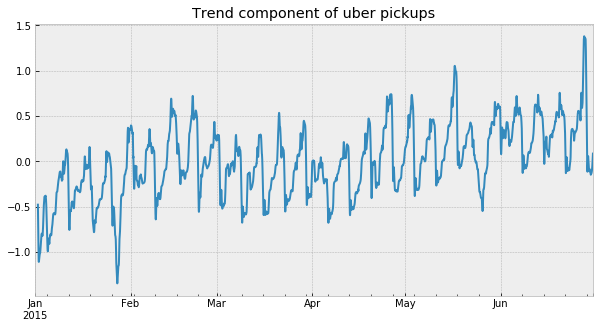

In [40]:
trend.plot(kind='line',title='Trend component of uber pickups')

In [41]:
decomp = df['total_pickups'][23:] - trend[23:] - seasonal[23:]

We can now detect anomalies by looking at events that are $n$ times larger than the standard deviation. Tuning this parameter will depend on how susceptible to false positives/false negatives we wish to be. In the plots, we show two scenarios for events detected where a given value $x$ is 3 or 4 standard deviations above or below the mean value.

In [45]:
ub_3s = decomp.mean() + 3*decomp.std()
lb_3s = decomp.mean() - 3*decomp.std()

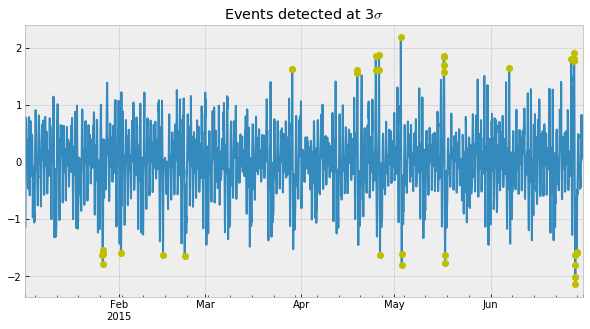

In [46]:
decomp.plot(kind='line')
decomp[(decomp>=ub_3s) | (decomp <=lb_3s)].plot(kind='line',style='yo',title='Events detected at 3$\sigma$')

In [47]:
df.index

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-06-30 14:00:00', '2015-06-30 15:00:00',
               '2015-06-30 16:00:00', '2015-06-30 17:00:00',
               '2015-06-30 18:00:00', '2015-06-30 19:00:00',
               '2015-06-30 20:00:00', '2015-06-30 21:00:00',
               '2015-06-30 22:00:00', '2015-06-30 23:00:00'],
              dtype='datetime64[ns]', length=4344, freq='H')

In [48]:
cd ~/Documents/timeseries_analysis/examples/

/Users/dmayett/Documents/timeseries_analysis/examples


In [61]:
s

0.041666666666666671